# IMT574 Problem Set 7: TF-IDF and k-Means Clustering

Introduction
This group problem set has three aims:
* get more experience with bag-of-words (BOW) and text processing
* learn the TF-IDF transform
* understand k-means clustering
* in terms of coding, get more experience with matrix manipulations.
We are using a dataset of Amazon reviews. It is compiled of three topics and contains ∼200k reviews. You will read those, convert into TF-IDF form, and use k-means clustering to analyze the results. Finally, check the resulting clusters and see how well-defined are the clusters. The trick is that you have to implement TF-IDF and k-means algorithms yourself! When implemented well, the code runs ∼30 iterations in a few minutes for 10k reviews, the memory consumption is ∼2G per 10k reviews. So you probably want to work on a subset of reviews only. Please submit a) your code (notebooks, rmd, whatever) and b) the results in a final output form (html or pdf).

Amazon Reviews
The data is downloaded from http://jmcauley.ucsd.edu/data/amazon/ and contains 3 topics: **baby**, **musical instruments**, and **beauty**. Musical instruments is the smallest collection you won't see many of these when inspecting the results. The original json files are transformed into csv, and contain four variables, date, summary, review, and rating. In the current context you only need review as we work with an unsupervised method.



In [1]:
#IPython is what you are using now to run the notebook
import IPython
print( "IPython version:      %6.6s (need at least 1.0)" % IPython.__version__)

# Numpy is a library for working with arrays and matrices
import numpy as np
print( "Numpy version:        %6.6s (need at least 1.7.1)" % np.__version__)

# SciPy implements many different numerical algorithms
import scipy as sp
print( "SciPy version:        %6.6s (need at least 0.12.0)" % sp.__version__)

# Pandas makes working with data tables easier
import pandas as pd
print( "Pandas version:       %6.6s (need at least 0.11.0)" % pd.__version__)

# Module for plotting
import matplotlib.pyplot as plt  
from pylab import *
print( "Mapltolib version:    %6.6s (need at least 1.2.1)" %
       matplotlib.__version__)
%matplotlib inline
# necessary for in-line graphics

# SciKit Learn implements several Machine Learning algorithms
import sklearn
print( "Scikit-Learn version: %6.6s (need at least 0.13.1)" %
       sklearn.__version__)
import os


# for certain system-related functions

from scipy import stats

import statsmodels.formula.api as smf

IPython version:       7.8.0 (need at least 1.0)
Numpy version:        1.16.5 (need at least 1.7.1)
SciPy version:         1.3.1 (need at least 0.12.0)
Pandas version:       0.25.1 (need at least 0.11.0)
Mapltolib version:     3.1.1 (need at least 1.2.1)
Scikit-Learn version: 0.21.3 (need at least 0.13.1)


### 1 Explore and clean the data
First, let's load data and take a closer look at it.

1. Load the data. Remove all the missing and empty observations of review.

2. You almost certainly need to take a subset unless you run this on a beefy server. I'd recommend to start with 1000 reviews and scale it up to 10 or 20k when the things seem to work well (requires 2-4G of RAM). Note: please take a random sample, not just first n lines. If you want to make your results replicable, use np.random.seed.

3. Take a look some of the reviews. Just be looking at those, imagine how you might cluster those into a few categories.


In [2]:
#1.1 Load the data
#data = pd.read_csv("amazon-reviews.csv",sep = ",",skiprows=2)
data = pd.read_csv("amazon-reviews.csv.bz2",sep = "\t",error_bad_lines=False)

In [3]:
data.shape

(205331, 4)

In [4]:
data.head(10)

,date,summary,review,rating
0,2013-07-16,Awesine,Perfect for new parents. We were able to keep ...,5
1,2013-06-29,Should be required for all new parents!,This book is such a life saver. It has been s...,5
2,2014-03-19,Grandmother watching baby,Helps me know exactly how my babies day has go...,5
3,2013-08-17,repeat buyer,I bought this a few times for my older son and...,5
4,2014-04-01,Great,I wanted an alternative to printing out daily ...,4
5,2014-05-10,"Great for basics, but not detail","This is great for basics, but I wish the space...",4
6,2013-07-17,Perfect for the working mom,My 3 month old son spend half of his days with...,5
7,2013-01-27,Great for newborns,This book is perfect! I'm a first time new mo...,5
8,2014-04-22,"It's ok, but I liked a regular weekly planner ...","I wanted to love this, but it was pretty expen...",3
9,2013-11-19,Best for Tracking!,The Baby Tracker brand books are the absolute ...,5


In [5]:
variables = data.columns
print("The list of variables is as following: " + str(variables))

The list of variables is as following: Index(['date', 'summary', 'review', 'rating'], dtype='object')


In [6]:
data.review.isnull().sum()

80

In [7]:
(data.review == ' ').sum()

0

There are no white spaces or empty fields in reviews column.

In [8]:
#Remove all the missing and empty observations of review.
data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [9]:
data.shape

(205236, 4)

In [10]:
#1.2 random_state=10 is the seed for the random number generator from numpy
DataSample = data.sample(n=1000,random_state=5,replace=False)

In [11]:
DataSample.reset_index(drop=True, inplace=True)

In [12]:
DataSample.head(10)

,date,summary,review,rating
0,2014-03-12,"Nice material, fit is off. Probably don't need...",My mother bought the naturepedic mattress for ...,3
1,2014-01-10,nice,I think this rattle is really cool because it'...,5
2,2013-04-23,not bad,I love the idea of these spoons. It would be ...,3
3,2013-01-10,Great item for the kids,This is a great item but the bag that it comes...,4
4,2012-08-01,"Nice glass bottle, terrible nipple","I like that these are glass bottles, but the n...",3
5,2012-12-28,Perfect,Accurately described and worked perfectly in m...,5
6,2013-04-19,It works fine but the sheet is not included,This is a great travel bed. It works fine. Eas...,3
7,2013-12-31,Happy Customer!,It was the perfect gift for my little girl. Sh...,5
8,2012-04-27,Best Bibs Ever!,I love love love these bibs! After getting on...,5
9,2011-12-14,Buyer beware! Not biodegrable and not made is ...,Purchased the Neat Solutions Baby Einstein 30-...,1


**1.3
I will cluster the reviews based on the keywords such as baby, parents, husband, wife, grandparents, bottle etc. for baby products and so on for other categories such as musical instruments and beauty.**

### 2 Implement TF-IDF transform

Here your task is the following: use the sklearn's CountVectorizer, but unlike in the Naive Bayes exercise, don't use binary=True option, i.e. get the actual counts, not just presence/absence of the words. Transform your (subset of) reviews into BOW. Next, apply TF-IDF transform on the BOW so that you end up with a TF-IDF matrix. This is what you will use later for clustering.

* transform a subset (1000 or so) reviews into BOW using sklearns CountVectorizer. Ensure you get the actual count of words, not just binary presence/absence.

In [13]:
#tokenize text with Tfidf
#from sklearn.feature_extraction.text import TfidfVectorizer
#from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df = 0,binary=False) 
        
text = DataSample.review.values
X = cv.fit_transform(text)
#print(cv.get_feature_names())
#print(X.toarray())



In [14]:
Xdf=X.toarray()
Xdf = pd.DataFrame(Xdf,columns=cv.get_feature_names())
Xdf.reset_index()
Xdf.head()

,00,000,01,02,04,09,10,100,1000,100th,...,zipped,zipper,zippered,zippy,zips,zoe,zoli,zoo,zooming,zwilling
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* transform the BOW into tf-idf matrix. TF-IDF is a way to weigh the frequency and importance of the words, so common words get low weight and specic words, present in a subset of documents get a high weight. Consult lecture notes, section 6.1.2 about tf-idf. Note: there are many ways to dene TF-IDF. If you are using another denition, please cite the source. You may also consider initially cheating by using sklearns TfidfVectorizer to test the next part of the code, and implement your own later.


In [15]:
tf_df = log(1+Xdf)

The tf_df matrix has the term frequency for every word in every review.

In [16]:
N = Xdf.shape[0] #N is the number of reviews

In [17]:
N

1000

For every word, we have to find the number of documents that have that word. Which simply means that if in our Xdf, if a particular value is greater than 0, then the word(present in the column) occurs in the review(represented in the row)

In [18]:
#counting for every word, it appears in how many documents
frequency_words= (Xdf>0).sum(axis=0)

In [19]:
frequency_words[0:5] #checking for a few words

00     1
000    1
01     1
02     1
04     1
dtype: int64

In [20]:
frequency_words.shape

(7175,)

In [21]:
idf = log(N/(1+frequency_words)) #finding idf for every word

In [22]:
idf[0:5]

00     6.214608
000    6.214608
01     6.214608
02     6.214608
04     6.214608
dtype: float64

In [23]:
idf_dictionary = idf.to_dict() #converting to a dictionary

In [24]:
idf_df = pd.DataFrame(idf_dictionary, index = [0]) #makinga matrix of idf

In [25]:
idf_df

,00,000,01,02,04,09,10,100,1000,100th,...,zipped,zipper,zippered,zippy,zips,zoe,zoli,zoo,zooming,zwilling
0,6.214608,6.214608,6.214608,6.214608,6.214608,6.214608,3.688879,4.60517,5.521461,6.214608,...,5.521461,4.60517,5.521461,6.214608,6.214608,6.214608,6.214608,5.809143,6.214608,6.214608


In [26]:
tf_df.shape

(1000, 7175)

In [27]:
idf_df.shape

(1, 7175)

In [28]:
tf_idf_df = tf_df * idf #taking elementwise multiplication of idf with every row of tf matrix
tf_idf_df.head(10)

,00,000,01,02,04,09,10,100,1000,100th,...,zipped,zipper,zippered,zippy,zips,zoe,zoli,zoo,zooming,zwilling
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.556936,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Its our tf-idf matrix.

### 3- Implement k-Means Clustering

***Q3.1-Pick k random reviews (remember: we work on TF-IDF matrix, so we talk about picking their
TF-IDF) and assign those to be the cluster centers.***

In [29]:
tf_idf_df_cluster = tf_idf_df.copy() #making a copy of tf-idf matrix to add clusters, cosine similarities, norms for every review

In [30]:
tf_idf_df_cluster

,00,000,01,02,04,09,10,100,1000,100th,...,zipped,zipper,zippered,zippy,zips,zoe,zoli,zoo,zooming,zwilling
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.556936,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We are choosing k =3 for k-means clustering. We can choose any three vectors for cluster centres. So we would initially choose the first 3 reviews to depict the vectors for 3 cluster centroids.

In [31]:
cluster_centres_df = tf_idf_df_cluster[0:3] #initially just the 1st three rows for 3 cluster centres

In [32]:
cluster_centres_df

,00,000,01,02,04,09,10,100,1000,100th,...,zipped,zipper,zippered,zippy,zips,zoe,zoli,zoo,zooming,zwilling
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***Q3.2-assign all reviews into arbitrary clusters (all to the first is fine).***

In [33]:
#We are adding another column for cluster and assigning every row to cluster 1
tf_idf_df_cluster['assigned_cluster'] =1

***Q3.3- compute the norm of all review vectors***

The last column is for cluster, so we would calculate the norm for every row without considering the last column

In [34]:
norms = np.apply_along_axis(np.linalg.norm, 1, tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['assigned_cluster'])]) 

In [35]:
#adding the column for norm
tf_idf_df_cluster['calculated_norm']  = norms

***Q3.4-compute the norm of the cluster center vectors***

In [36]:
cluster_norms = np.apply_along_axis(np.linalg.norm, 1, cluster_centres_df)

In [37]:
cluster_centres_df['cluster_norm'] = cluster_norms

C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
cluster_centres_df

,00,000,01,02,04,09,10,100,1000,100th,...,zipper,zippered,zippy,zips,zoe,zoli,zoo,zooming,zwilling,cluster_norm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.389676
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.637357
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.275151


In [39]:
#set(tf_idf_df_cluster.columns) - set(cluster_centres_df.columns) 

***Q3.5-for each cluster, compute the cosine similarity between the reviews and the corresponding cluster
centers.
Try to use vectors/matrices and numpy vectorized operations as much as you can and avoid loops.
You may easily achieve 100x speed-up in this way. Loops are fine in terms of grading, but much
slower.***

We have to find the cosine similarity of the three cluster centres with every review. For every cluster, we can find it by taking the dot product of the cluster vector and the review vector; then divide the result by the product of norms of the cluster vector and review vector. When we talk about review vector, we mean the tf-idf dataframe which we made for the reviews.

In [40]:
#cosine similarity of every review vector with the 1st cluster vector. 

#The last two columns of review dataframe are for norm and cluster.
#So we are not taking the last two columns.
# The last column of the cluster dataframe is of norm, so we are not taking its last column

dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[0,:])
norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][0]) #finding the denominator
Cosine_Similarity_c1 = np.divide(dot_products,norm_products)

In [41]:
#cosine similarity of every review vector with the 2nd cluster vector. 

#The last two columns of review dataframe are for norm and cluster.
#So we are not taking the last two columns.
# The last column of the cluster dataframe is of norm, so we are not taking its last column

dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[1,:])
norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][1]) #finding the denominator
Cosine_Similarity_c2 = np.divide(dot_products,norm_products)

In [42]:
#cosine similarity of every review vector with the 3rd cluster vector. 

#The last two columns of review dataframe are for norm and cluster.
#So we are not taking the last two columns.
# The last column of the cluster dataframe is of norm, so we are not taking its last column

dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[2,:])
norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][2]) #finding the denominator
Cosine_Similarity_c3 = np.divide(dot_products,norm_products)

In [43]:
cluster_centres_df

,00,000,01,02,04,09,10,100,1000,100th,...,zipper,zippered,zippy,zips,zoe,zoli,zoo,zooming,zwilling,cluster_norm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.389676
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.637357
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.275151


In [44]:
#We add these the columns for cosine similarity with three clusters in the dataframe having reviews

tf_idf_df_cluster['CosineSimilarity_c1'] = Cosine_Similarity_c1 #for cluster 1
tf_idf_df_cluster['CosineSimilarity_c2'] = Cosine_Similarity_c2 #for cluster 2
tf_idf_df_cluster['CosineSimilarity_c3'] = Cosine_Similarity_c3 #for cluster 3


***Q3.6-now assign each review to the cluster, center of which is the closest to it in terms of cosine similarity.***

So we have added three columns for cosine similarity of every row with the three clusters. We would reassign the cluster value based on highest cosine similarity.

In [45]:
#assigning the cluster again
#each row gets assigned to that cluter with which its cosine similarity is the highest

tf_idf_df_cluster['assigned_cluster'] = tf_idf_df_cluster.apply(lambda x: 1 if x.CosineSimilarity_c1 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c3
                                                      else 2 if  x.CosineSimilarity_c2 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c3
                                                       else 3 ,
                                                       axis = 1
                                                      )

In [46]:
tf_idf_df_cluster.assigned_cluster.value_counts()

3    494
1    343
2    163
Name: assigned_cluster, dtype: int64

***Q3.7-did any of the reviews change cluster?***

I had initially assigned all the reviews to cluster 1, but a lot of reviews have gone to cluster 2 and 3. We might have to run the algorithm again.

***Q3.8-compute new cluster centers by taking mean (centroid) of all reviews that belong to each cluster.***

We have to calculate the cluster centres based on the rows assigned to various clusters. For the rows of every given cluster, the mean of the features is the vector to denote new cluster centre.

In [47]:
tf_idf_df_cluster.head(5)

,00,000,01,02,04,09,10,100,1000,100th,...,zoe,zoli,zoo,zooming,zwilling,assigned_cluster,calculated_norm,CosineSimilarity_c1,CosineSimilarity_c2,CosineSimilarity_c3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,21.389676,1.000000,0.020756,0.025429
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,14.637357,0.020756,1.000000,0.020066
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3,12.275151,0.025429,0.020066,1.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,14.067349,0.054210,0.061553,0.014964
4,0.0,0.0,0.0,0.0,0.0,0.0,2.556936,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3,14.561984,0.010884,0.002965,0.116716


The last 5 columns are for cluster,norm,CosineSimilarity_c1,CosineSimilarity_c2,CosineSimilarity_c3. So we would take mean of variables except these for different clusters.

In [48]:
#for cluster 1
only_cluster1_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==1]

In [49]:
only_cluster1_df.shape

(343, 7180)

In [50]:
centre1 = only_cluster1_df[only_cluster1_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3'])].mean()

In [51]:
#centre1 is the vector for centre of cluster 1. 
#The last column of cluster_centres_df is the norm for every cluster centre vector
#So we accordingly put centre1 in the row index of cluster_centres_df
cluster_centres_df.iloc[0,:-1] = centre1

C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [52]:
#for cluster 2
only_cluster2_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==2]

In [53]:
centre2 = only_cluster2_df[only_cluster2_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3'])].mean()

In [54]:
#centre2 is the vector for centre of cluster 1. 
#The last column of cluster_centres_df is the norm for every cluster centre vector
#So we accordingly put centre2 in the row index 1 of cluster_centres_df
cluster_centres_df.iloc[1,:-1] = centre2

C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [55]:
#for cluster 3
only_cluster3_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==3]

In [56]:
centre3 = only_cluster3_df[only_cluster3_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3'])].mean()

In [57]:
#centre3 is the vector for centre of cluster 1. 
#The last column of cluster_centres_df is the norm for every cluster centre vector
#So we accordingly put centre3 in the row index 2 of cluster_centres_df
cluster_centres_df.iloc[2,:-1] = centre3

C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [58]:
cluster_centres_df

,00,000,01,02,04,09,10,100,1000,100th,...,zipper,zippered,zippy,zips,zoe,zoli,zoo,zooming,zwilling,cluster_norm
0,0.00000,0.025117,0.012559,0.012559,0.00000,0.000000,0.063998,0.062863,0.000000,0.012559,...,0.027919,0.022316,0.012559,0.012559,0.012559,0.000000,0.000000,0.012559,0.000000,21.389676
1,0.00000,0.000000,0.000000,0.000000,0.00000,0.026427,0.109807,0.058750,0.000000,0.000000,...,0.050622,0.000000,0.000000,0.000000,0.000000,0.000000,0.024703,0.000000,0.000000,14.637357
2,0.00872,0.000000,0.000000,0.000000,0.00872,0.000000,0.046584,0.006462,0.023242,0.000000,...,0.029626,0.012279,0.000000,0.000000,0.000000,0.013821,0.008151,0.000000,0.013821,12.275151


***Q3.9 repeat from 4. In my experience, you need 30 iterations, more for more clusters.***

We have to repeat from Q3.4 where we calculated the cluster centre norms. We would run 30 iterations to reassign to clusters.

In [59]:
for i in range(30):
    
    #finding the norms for cluster centres
    cluster_norms = np.apply_along_axis(np.linalg.norm, 1, cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])])
    #cluster_norms = np.apply_along_axis(np.linalg.norm, 1, cluster_centres_df) 
    cluster_centres_df['cluster_norm'] = cluster_norms
    
    #cosine similarity of every review with cluster 1
    dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[0,:])
    norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][0]) #finding the denominator
    Cosine_Similarity_c1 = np.divide(dot_products,norm_products)
    
    #cosine similarity of every review with cluster 2
    dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[1,:])
    norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][1]) #finding the denominator
    Cosine_Similarity_c2 = np.divide(dot_products,norm_products)
    
    #cosine similarity of every review with cluster 3
    dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[2,:])
    norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][2]) #finding the denominator
    Cosine_Similarity_c3 = np.divide(dot_products,norm_products)
    
    #updating the cosine similarity columns in tf-idf matrix for each of the three clusters
    tf_idf_df_cluster['CosineSimilarity_c1'] = Cosine_Similarity_c1 #for cluster 1
    tf_idf_df_cluster['CosineSimilarity_c2'] = Cosine_Similarity_c2 #for cluster 2
    tf_idf_df_cluster['CosineSimilarity_c3'] = Cosine_Similarity_c3 #for cluster 3
    
    #every review gets assigned to the cluster with which it has highest cosine similarity
    tf_idf_df_cluster['assigned_cluster'] = tf_idf_df_cluster.apply(lambda x: 1 if x.CosineSimilarity_c1 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c3
                                                      else 2 if  x.CosineSimilarity_c2 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c3
                                                       else 3 ,
                                                       axis = 1
                                                      )
    
    #computing the new cluster centre vectors and putting in cluster_centres_df
    only_cluster1_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==1]
    centre1 = only_cluster1_df[only_cluster1_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3'])].mean()
    cluster_centres_df.iloc[0,:-1] = centre1
    
    only_cluster2_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==2]
    centre2 = only_cluster2_df[only_cluster2_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3'])].mean()
    cluster_centres_df.iloc[1,:-1] = centre2
    
    only_cluster3_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==3]
    centre3 = only_cluster3_df[only_cluster3_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3'])].mean()
    cluster_centres_df.iloc[2,:-1] = centre3
    

C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [60]:
tf_idf_df_cluster.assigned_cluster.value_counts()

3    467
1    348
2    185
Name: assigned_cluster, dtype: int64

I ran the above code for 30 iterations and find the number of reviews in various clusters. When I re run it I find hardly a few reviews change their cluster. So our k-means clutering is stable after 30 iterations.

You final result should be a nice design matrix X with condition number that is not outrageously large. When the code runs, try to explain what exactly does it do:

1. What kind of properties of the reviews is the algorithm considering? What constitutes similar reviews?


KMeans normally works with numbers only: we need to have numbers. To perform feature extraction we use the concept of tf-idf. This statistic uses term frequency and inverse document frequency. In short: we use statistics to get to numerical features. TF-IDF is a way to measure how important a word is to a document. The TF measures how frequently a term appears in a documentThe IDF measures how important a term is.

The TF-IDF value increases in relation to the number of times a word appears in the document and is offset by the number of existing documents that contain the word. Similar reviews will have keywords that belong to that category. For example baby products category will have words like milk bottles, diapers, baby cot, baby toys and son on. 

### 4- Play and Analyze Your Clusters

***Q4.1- split the (subset of) reviews into clusters***

In [61]:
reviews_cluster1 = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==1]

In [62]:
reviews_cluster2 = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==2]

In [63]:
reviews_cluster3 = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==3]

***Q4.2- print out a set of reviews from each cluster, so you can see and compare the results.***

#### Printing 10 reviews from each cluster.

Creating a list of indices belonging to a given cluster

In [64]:
ReviewsCluster1index=reviews_cluster1.index.tolist() 
len(ReviewsCluster1index)

348

In [65]:
ReviewsCluster2index=reviews_cluster2.index.tolist() 
len(ReviewsCluster2index)

185

In [66]:
ReviewsCluster3index=reviews_cluster3.index.tolist() 
len(ReviewsCluster3index)

467

In [67]:
#some sample indices we got above
ReviewsCluster1index[0:10]

[0, 5, 6, 13, 18, 20, 23, 24, 28, 33]

In [68]:
#Printing 10 reviews belonging to Cluster 1.   
for i,index in enumerate(ReviewsCluster1index[0:10],1):
    print(i, '. ' + DataSample.review.values[index], sep='',end='')
    print()
    print()

1. My mother bought the naturepedic mattress for us. Before it arrived, I figured I would order the cover. I wish I would have waited until after the mattress arrived. If you get a good mattress (like the naturepedic), it looks like it is waterproof so you probably don't need an additional cover. The naturepedic one, while nice, doesn't quite fit the mattress just right and bunches up in weird spots. It creeps out from below the sheet and I end up spending more time than I'd like to admit tucking the pad into the sheet so it doesn't show.

2. Accurately described and worked perfectly in my Medela pump in style advanced. Good price for what it is. I couldn't find what I needed in stores.

3. This is a great travel bed. It works fine. Easy to inflate. But the yellow sheet that is shown does not come with it!!

4. Pictured is a Baby Aspen robe, it looks plush and comfy. I ordered two for my boys and thought &#34;this would be awesome&#34; for them. Unfortunately, after washing and drying 

In [69]:
#Printing 10 reviews belonging to Cluster 2.   
for i,index in enumerate(ReviewsCluster2index[0:10],1):
    print(i, '. ' + DataSample.review.values[index], sep='',end='')
    print()
    print()

1. I think this rattle is really cool because it's got a nice thick handle and multiple chewable objects. We've dropped it multiple times on the floor and it's been thrown around and hasn't broken yet. The texture of the wood is fun for baby and it doesn't taste bad.

2. This is a great item but the bag that it comes with has no handle to carry and the plastic piece to pull the cord broke in half the first time using. Must of been cracked before I used, broke very easy. I would buy this again just wish it had a handle to make it easy to carry.  I bought 4 and the kids love them.  Good luck.

3. I use this for recording guitars as well as live vocals.  I've knocked this microphone around a decent amount, and it is plenty rugged.  I couldn't be happier with it.

4. Have been using this for a month and really like it. Perfect size, shape, and can take on the road. Inflates in a minute. Only complaint is location of floor valve. Right under the privates. So instead of pressing the valve in

In [70]:
#Printing reviews belonging to Cluster 3.   
for i,index in enumerate(ReviewsCluster3index[0:10],1):
    print(i, '. ' + DataSample.review.values[index], sep='',end='')
    print()
    print()

1. I love the idea of these spoons.  It would be nice if they were a little more narrow.  My son opens his mouth as wide as he can when we use these spoons.  He is 11 months and not a little guy and still these are a bit wide for him.

2. I like that these are glass bottles, but the nipple that is included is way too small.  My son's mouth fits completely over it, and he still has a shallow latch.  He's only 10 weeks old!  I decided to keep the bottles and use them for storage.  You could try pairing the bottles with another nipple as well.  Also, Target sells this pack for $5.

3. It was the perfect gift for my little girl. She's only 20 months old so she gets to hold it just fine around the house playing her favorites songs from the show. Well made and the characters are just too adorable.

4. I love love love these bibs!  After getting one as a gift, we purchased the 2-pack to add to our collection.  We have 2 small children and use these with every meal.  I only wish that I had mor

***Q4.3- comment on what do you see. How good a job does the algorithm in picking up meaningful similarities between reviews? Note: do not expect the clusters to be very clear. There will be ones that are rather obvious (all taking about baby seats for instance) and ones that just look like a mess of all kind of things. There are clusters that are clearly taken because some other common traits (say, talking about color, including lipstick, baby toy, and a music player). You also need more than a few clusters (say, 15-20) to see more meaningful content.***

Looks like the clustering alghorithm has done a good job at roughly clustering similar sounding reviews to each cluster. For instance the cluster 1 has reveiws that belong to a category of bedding and baby products and has similar sounding words such as cushion, padding, mattress etc. Furthermore if you see reviews in cluster 2 are more mixed with few unrelated reviews clustered together such as lip gloss a beauty product with bassinet which is a musical instrument. So looks like we may need more than 3 clusters to get a meaningful context. The last cluster has more baby products and reviews related to the same with a few exceptions here and there. For now we are happy with the algorithm as it cluster majority of reviews in the right basket(cluster). Let us experiment by playing with the k value i.e number of clusters.

***Q4.4-play with a few different k values. If your code works well, now it is time to scale up to as large
sample as you can (I can do 30k in ~5 mins on an oldish desktop).***

### We would try with  k= 2. We would have to repeat all the steps we did in Q3.

In [71]:
tf_idf_df_cluster = tf_idf_df.copy() #making a copy of tf-idf matrix to add clusters, cosine similarities, norms for every review

We are making 2 clusters, so choosing top 2 rows of tf-idf matrix for our cluster centre vectors

In [72]:
cluster_centres_df = tf_idf_df_cluster[0:2] #initially just the 1st three rows for 3 cluster centres

In [73]:
#We are adding another column for cluster and assigning every row to cluster 1
tf_idf_df_cluster['assigned_cluster'] =1

The last column is for cluster, so we would calculate the norm for every row without considering the last column

In [74]:
norms = np.apply_along_axis(np.linalg.norm, 1, tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['assigned_cluster'])]) 

In [75]:
#adding the column for norm
tf_idf_df_cluster['calculated_norm']  = norms

In [76]:
#computing norms of cluster centre vectors
cluster_norms = np.apply_along_axis(np.linalg.norm, 1, cluster_centres_df)

In [77]:
#adding a column for cluster norms
cluster_centres_df['cluster_norm'] = cluster_norms

C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [78]:
#cosine similarity of every review vector with the 1st cluster vector. 

#The last two columns of review dataframe are for norm and cluster.
#So we are not taking the last two columns.
# The last column of the cluster dataframe is of norm, so we are not taking its last column

dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[0,:])
norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][0]) #finding the denominator
Cosine_Similarity_c1 = np.divide(dot_products,norm_products)

In [79]:
#cosine similarity of every review vector with the 2nd cluster vector. 

#The last two columns of review dataframe are for norm and cluster.
#So we are not taking the last two columns.
# The last column of the cluster dataframe is of norm, so we are not taking its last column

dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[1,:])
norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][1]) #finding the denominator
Cosine_Similarity_c2 = np.divide(dot_products,norm_products)

In [80]:
#We add these the columns for cosine similarity with two clusters in the dataframe having reviews

tf_idf_df_cluster['CosineSimilarity_c1'] = Cosine_Similarity_c1 #for cluster 1
tf_idf_df_cluster['CosineSimilarity_c2'] = Cosine_Similarity_c2 #for cluster 2


In [81]:
#assigning the cluster again
#each row gets assigned to that cluter with which its cosine similarity is the highest

tf_idf_df_cluster['assigned_cluster'] = tf_idf_df_cluster.apply(lambda x: 1 if x.CosineSimilarity_c1 >= x.CosineSimilarity_c2 
                                                      else 2 ,
                                                       axis = 1
                                                      )

In [82]:
tf_idf_df_cluster.assigned_cluster.value_counts()

1    686
2    314
Name: assigned_cluster, dtype: int64

We have to calculate the cluster centres based on the rows assigned to various clusters. For the rows of every given cluster, the mean of the features is the vector to denote new cluster centre.

In [83]:
#for cluster 1
only_cluster1_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==1]

In [84]:
centre1 = only_cluster1_df[only_cluster1_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2'])].mean()

In [85]:
#centre1 is the vector for centre of cluster 1. 
#The last column of cluster_centres_df is the norm for every cluster centre vector
#So we accordingly put centre1 in the row index of cluster_centres_df
cluster_centres_df.iloc[0,:-1] = centre1

C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [86]:
#for cluster 2
only_cluster2_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==2]

In [87]:
centre2 = only_cluster2_df[only_cluster2_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2'])].mean()

In [88]:
#centre2 is the vector for centre of cluster 1. 
#The last column of cluster_centres_df is the norm for every cluster centre vector
#So we accordingly put centre2 in the row index 1 of cluster_centres_df
cluster_centres_df.iloc[1,:-1] = centre2

C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [89]:
for i in range(30):
    
    #finding the norms for cluster centres
    cluster_norms = np.apply_along_axis(np.linalg.norm, 1, cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])])
    #cluster_norms = np.apply_along_axis(np.linalg.norm, 1, cluster_centres_df) 
    cluster_centres_df['cluster_norm'] = cluster_norms
    
    #cosine similarity of every review with cluster 1
    dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[0,:])
    norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][0]) #finding the denominator
    Cosine_Similarity_c1 = np.divide(dot_products,norm_products)
    
    #cosine similarity of every review with cluster 2
    dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[1,:])
    norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][1]) #finding the denominator
    Cosine_Similarity_c2 = np.divide(dot_products,norm_products)
    
    
    
    #updating the cosine similarity columns in tf-idf matrix for each of the three clusters
    tf_idf_df_cluster['CosineSimilarity_c1'] = Cosine_Similarity_c1 #for cluster 1
    tf_idf_df_cluster['CosineSimilarity_c2'] = Cosine_Similarity_c2 #for cluster 2
    
    
    #every review gets assigned to the cluster with which it has highest cosine similarity
    tf_idf_df_cluster['assigned_cluster'] = tf_idf_df_cluster.apply(lambda x: 1 if x.CosineSimilarity_c1 >= x.CosineSimilarity_c2 else 2  ,
                                                       axis = 1
                                                      )
    
    #computing the new cluster centre vectors and putting in cluster_centres_df
    only_cluster1_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==1]
    centre1 = only_cluster1_df[only_cluster1_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2'])].mean()
    cluster_centres_df.iloc[0,:-1] = centre1
    
    only_cluster2_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==2]
    centre2 = only_cluster2_df[only_cluster2_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2'])].mean()
    cluster_centres_df.iloc[1,:-1] = centre2
    
    

C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [90]:
tf_idf_df_cluster.assigned_cluster.value_counts()

1    604
2    396
Name: assigned_cluster, dtype: int64

### Let us try with k=10 and repeat the steps above.

In [91]:
tf_idf_df_cluster = tf_idf_df.copy() #making a copy of tf-idf matrix to add clusters, cosine similarities, norms for every review

We are making 10 clusters, so choosing top 10 rows of tf-idf matrix for our cluster centre vectors

In [92]:
cluster_centres_df = tf_idf_df_cluster[0:10] #initially just the 1st ten rows for 10 cluster centres

In [93]:
#We are adding another column for cluster and assigning every row to cluster 1
tf_idf_df_cluster['assigned_cluster'] =1

The last column is for cluster, so we would calculate the norm for every row without considering the last column

In [94]:
norms = np.apply_along_axis(np.linalg.norm, 1, tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['assigned_cluster'])]) 

In [95]:
#adding the column for norm
tf_idf_df_cluster['calculated_norm']  = norms

In [96]:
#computing norms of cluster centre vectors
cluster_norms = np.apply_along_axis(np.linalg.norm, 1, cluster_centres_df)

In [97]:
#adding a column for cluster norms
cluster_centres_df['cluster_norm'] = cluster_norms

C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [98]:
#cosine similarity of every review vector with the 1st cluster vector. 

#The last two columns of review dataframe are for norm and cluster.
#So we are not taking the last two columns.
# The last column of the cluster dataframe is of norm, so we are not taking its last column

dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[0,:])
norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][0]) #finding the denominator
Cosine_Similarity_c1 = np.divide(dot_products,norm_products)

In [99]:
#cosine similarity of every review vector with the 2nd cluster vector. 

#The last two columns of review dataframe are for norm and cluster.
#So we are not taking the last two columns.
# The last column of the cluster dataframe is of norm, so we are not taking its last column

dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[1,:])
norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][1]) #finding the denominator
Cosine_Similarity_c2 = np.divide(dot_products,norm_products)

In [100]:
#cosine similarity of every review vector with the 3rd cluster vector. 

#The last two columns of review dataframe are for norm and cluster.
#So we are not taking the last two columns.
# The last column of the cluster dataframe is of norm, so we are not taking its last column

dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[2,:])
norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][2]) #finding the denominator
Cosine_Similarity_c3 = np.divide(dot_products,norm_products)

In [101]:
#cosine similarity of every review vector with the 4th cluster vector. 

#The last two columns of review dataframe are for norm and cluster.
#So we are not taking the last two columns.
# The last column of the cluster dataframe is of norm, so we are not taking its last column

dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[3,:])
norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][3]) #finding the denominator
Cosine_Similarity_c4 = np.divide(dot_products,norm_products)

In [102]:
#cosine similarity of every review vector with the 5th cluster vector. 

#The last two columns of review dataframe are for norm and cluster.
#So we are not taking the last two columns.
# The last column of the cluster dataframe is of norm, so we are not taking its last column

dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[4,:])
norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][4]) #finding the denominator
Cosine_Similarity_c5 = np.divide(dot_products,norm_products)

In [103]:
#cosine similarity of every review vector with the 6th cluster vector. 

#The last two columns of review dataframe are for norm and cluster.
#So we are not taking the last two columns.
# The last column of the cluster dataframe is of norm, so we are not taking its last column

dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[5,:])
norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][5]) #finding the denominator
Cosine_Similarity_c6 = np.divide(dot_products,norm_products)

In [104]:
#cosine similarity of every review vector with the 7th cluster vector. 

#The last two columns of review dataframe are for norm and cluster.
#So we are not taking the last two columns.
# The last column of the cluster dataframe is of norm, so we are not taking its last column

dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[6,:])
norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][6]) #finding the denominator
Cosine_Similarity_c7 = np.divide(dot_products,norm_products)

In [105]:
#cosine similarity of every review vector with the 8th cluster vector. 

#The last two columns of review dataframe are for norm and cluster.
#So we are not taking the last two columns.
# The last column of the cluster dataframe is of norm, so we are not taking its last column

dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[7,:])
norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][7]) #finding the denominator
Cosine_Similarity_c8 = np.divide(dot_products,norm_products)

In [106]:
#cosine similarity of every review vector with the 9th cluster vector. 

#The last two columns of review dataframe are for norm and cluster.
#So we are not taking the last two columns.
# The last column of the cluster dataframe is of norm, so we are not taking its last column

dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[8,:])
norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][8]) #finding the denominator
Cosine_Similarity_c9 = np.divide(dot_products,norm_products)

In [107]:
#cosine similarity of every review vector with the 10th cluster vector. 

#The last two columns of review dataframe are for norm and cluster.
#So we are not taking the last two columns.
# The last column of the cluster dataframe is of norm, so we are not taking its last column

dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[9,:])
norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][9]) #finding the denominator
Cosine_Similarity_c10 = np.divide(dot_products,norm_products)

In [108]:
#We add these the columns for cosine similarity with two clusters in the dataframe having reviews

tf_idf_df_cluster['CosineSimilarity_c1'] = Cosine_Similarity_c1 #for cluster 1
tf_idf_df_cluster['CosineSimilarity_c2'] = Cosine_Similarity_c2 #for cluster 2
tf_idf_df_cluster['CosineSimilarity_c3'] = Cosine_Similarity_c3 #for cluster 3
tf_idf_df_cluster['CosineSimilarity_c4'] = Cosine_Similarity_c4 #for cluster 4
tf_idf_df_cluster['CosineSimilarity_c5'] = Cosine_Similarity_c5 #for cluster 5
tf_idf_df_cluster['CosineSimilarity_c6'] = Cosine_Similarity_c6 #for cluster 6
tf_idf_df_cluster['CosineSimilarity_c7'] = Cosine_Similarity_c7 #for cluster 7
tf_idf_df_cluster['CosineSimilarity_c8'] = Cosine_Similarity_c8 #for cluster 8
tf_idf_df_cluster['CosineSimilarity_c9'] = Cosine_Similarity_c9 #for cluster 9
tf_idf_df_cluster['CosineSimilarity_c10'] = Cosine_Similarity_c10 #for cluster 10

In [109]:
#assigning the cluster again
#each row gets assigned to that cluster with which its cosine similarity is the highest

tf_idf_df_cluster['assigned_cluster'] = tf_idf_df_cluster.apply(lambda x: 1 if x.CosineSimilarity_c1 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c3 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c4 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c5 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c6 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c7 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c8 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c9 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c10
                                                      else 2 if  x.CosineSimilarity_c2 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c3 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c4 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c5 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c6 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c7 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c8 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c9 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c10
                                                       else 3 if  x.CosineSimilarity_c3 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c3 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c3 >= x.CosineSimilarity_c4 and x.CosineSimilarity_c3 >= x.CosineSimilarity_c8 and x.CosineSimilarity_c3 >= x.CosineSimilarity_c5 and x.CosineSimilarity_c3 >= x.CosineSimilarity_c9 and x.CosineSimilarity_c3 >= x.CosineSimilarity_c6 and x.CosineSimilarity_c3 >= x.CosineSimilarity_c10 and x.CosineSimilarity_c3 >= x.CosineSimilarity_c7
                                                        else 4 if  x.CosineSimilarity_c4 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c4 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c4 >= x.CosineSimilarity_c3 and x.CosineSimilarity_c4 >= x.CosineSimilarity_c8 and x.CosineSimilarity_c4 >= x.CosineSimilarity_c5 and x.CosineSimilarity_c4 >= x.CosineSimilarity_c9 and x.CosineSimilarity_c4 >= x.CosineSimilarity_c6 and x.CosineSimilarity_c4 >= x.CosineSimilarity_c10 and x.CosineSimilarity_c4 >= x.CosineSimilarity_c7
                                                         else 5 if  x.CosineSimilarity_c5 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c5 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c5 >= x.CosineSimilarity_c3 and x.CosineSimilarity_c5 >= x.CosineSimilarity_c8 and x.CosineSimilarity_c5 >= x.CosineSimilarity_c4 and x.CosineSimilarity_c5 >= x.CosineSimilarity_c9 and x.CosineSimilarity_c5 >= x.CosineSimilarity_c6 and x.CosineSimilarity_c5 >= x.CosineSimilarity_c10 and x.CosineSimilarity_c5 >= x.CosineSimilarity_c7
                                                          else 6 if  x.CosineSimilarity_c6 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c6 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c6 >= x.CosineSimilarity_c3 and x.CosineSimilarity_c6 >= x.CosineSimilarity_c8 and x.CosineSimilarity_c6 >= x.CosineSimilarity_c4 and x.CosineSimilarity_c6 >= x.CosineSimilarity_c9 and x.CosineSimilarity_c6 >= x.CosineSimilarity_c5 and x.CosineSimilarity_c6 >= x.CosineSimilarity_c10 and x.CosineSimilarity_c6 >= x.CosineSimilarity_c7
                                                           else 7 if  x.CosineSimilarity_c7 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c7 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c7 >= x.CosineSimilarity_c3 and x.CosineSimilarity_c7 >= x.CosineSimilarity_c8 and x.CosineSimilarity_c7 >= x.CosineSimilarity_c4 and x.CosineSimilarity_c7 >= x.CosineSimilarity_c9 and x.CosineSimilarity_c7 >= x.CosineSimilarity_c5 and x.CosineSimilarity_c7 >= x.CosineSimilarity_c10 and x.CosineSimilarity_c7 >= x.CosineSimilarity_c6
                                                            else 8 if  x.CosineSimilarity_c8 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c8 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c8 >= x.CosineSimilarity_c3 and x.CosineSimilarity_c8 >= x.CosineSimilarity_c7 and x.CosineSimilarity_c8 >= x.CosineSimilarity_c4 and x.CosineSimilarity_c8 >= x.CosineSimilarity_c9 and x.CosineSimilarity_c8 >= x.CosineSimilarity_c5 and x.CosineSimilarity_c8 >= x.CosineSimilarity_c10 and x.CosineSimilarity_c8 >= x.CosineSimilarity_c6
                                                             else 9 if  x.CosineSimilarity_c9 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c9 >= x.CosineSimilarity_c3 and x.CosineSimilarity_c9 >= x.CosineSimilarity_c4 and x.CosineSimilarity_c9 >= x.CosineSimilarity_c5 and x.CosineSimilarity_c9 >= x.CosineSimilarity_c6 and x.CosineSimilarity_c9 >= x.CosineSimilarity_c7 and x.CosineSimilarity_c9 >= x.CosineSimilarity_c8 and x.CosineSimilarity_c9 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c9 >= x.CosineSimilarity_c10
                                                               else 10 ,
                                                       axis = 1
                                                      )

In [110]:
tf_idf_df_cluster.assigned_cluster.value_counts()

9     274
3     151
4     111
8     104
5      93
1      72
6      67
10     53
2      40
7      35
Name: assigned_cluster, dtype: int64

In [111]:
#for cluster 1
only_cluster1_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==1]
#for cluster 2
only_cluster2_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==2]
#for cluster 3
only_cluster3_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==3]
#for cluster 4
only_cluster4_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==4]
#for cluster 5
only_cluster5_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==5]
#for cluster 6
only_cluster6_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==6]
#for cluster 7
only_cluster7_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==7]
#for cluster 8
only_cluster8_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==8]
#for cluster 9
only_cluster9_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==9]
#for cluster 10
only_cluster10_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==10]

In [112]:
centre1 = only_cluster1_df[only_cluster1_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
centre2 = only_cluster2_df[only_cluster2_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
centre3 = only_cluster3_df[only_cluster3_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
centre4 = only_cluster4_df[only_cluster4_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
centre5 = only_cluster5_df[only_cluster5_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
centre6 = only_cluster6_df[only_cluster6_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
centre7 = only_cluster7_df[only_cluster7_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
centre8 = only_cluster8_df[only_cluster8_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
centre9 = only_cluster9_df[only_cluster9_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
centre10 = only_cluster10_df[only_cluster10_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()

In [113]:
cluster_centres_df.iloc[0,:-1] = centre1
cluster_centres_df.iloc[1,:-1] = centre2
cluster_centres_df.iloc[2,:-1] = centre3
cluster_centres_df.iloc[3,:-1] = centre4
cluster_centres_df.iloc[4,:-1] = centre5
cluster_centres_df.iloc[5,:-1] = centre6
cluster_centres_df.iloc[6,:-1] = centre7
cluster_centres_df.iloc[7,:-1] = centre8
cluster_centres_df.iloc[8,:-1] = centre9
cluster_centres_df.iloc[9,:-1] = centre10

C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [114]:
cluster_centres_df

,00,000,01,02,04,09,10,100,1000,100th,...,zipper,zippered,zippy,zips,zoe,zoli,zoo,zooming,zwilling,cluster_norm
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.091800,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.389676
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.637357
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033867,0.021139,0.000000,0.000000,...,0.042279,0.000000,0.000000,0.000000,0.000000,0.000000,0.026666,0.000000,0.000000,12.275151
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.038808,0.023035,0.057515,0.000000,0.000000,...,0.074337,0.034479,0.000000,0.000000,0.000000,0.000000,0.036276,0.000000,0.000000,14.067349
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.192458,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073413,14.561984
5,0.064293,0.000000,0.000000,0.000000,0.064293,0.000000,0.114490,0.075512,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.230281
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.123075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.176432
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024586,0.030693,0.000000,0.000000,...,0.030693,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.413016
8,0.000000,0.000000,0.015721,0.015721,0.000000,0.000000,0.074655,0.041764,0.027936,0.015721,...,0.041764,0.036106,0.000000,0.015721,0.015721,0.024918,0.000000,0.000000,0.000000,32.621728
9,0.000000,0.162552,0.000000,0.000000,0.000000,0.000000,0.000000,0.095458,0.072211,0.000000,...,0.060228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.081276,0.000000,38.342305


In [115]:
for i in range(30):
    
    #finding the norms for cluster centres
    cluster_norms = np.apply_along_axis(np.linalg.norm, 1, cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])])
    #cluster_norms = np.apply_along_axis(np.linalg.norm, 1, cluster_centres_df) 
    cluster_centres_df['cluster_norm'] = cluster_norms
    
    #cosine similarity of every review with cluster 1
    dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[0,:])
    norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][0]) #finding the denominator
    Cosine_Similarity_c1 = np.divide(dot_products,norm_products)
    
    #cosine similarity of every review with cluster 2
    dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[1,:])
    norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][1]) #finding the denominator
    Cosine_Similarity_c2 = np.divide(dot_products,norm_products)
    
    #cosine similarity of every review with cluster 3
    dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[2,:])
    norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][2]) #finding the denominator
    Cosine_Similarity_c3 = np.divide(dot_products,norm_products)
    
    #cosine similarity of every review vector with the 4th cluster vector. 
    dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[3,:])
    norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][3]) #finding the denominator
    Cosine_Similarity_c4 = np.divide(dot_products,norm_products)
    
    #cosine similarity of every review with cluster 5
    dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[4,:])
    norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][4]) #finding the denominator
    Cosine_Similarity_c5 = np.divide(dot_products,norm_products)
    
    #cosine similarity of every review with cluster 6
    dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[5,:])
    norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][5]) #finding the denominator
    Cosine_Similarity_c6 = np.divide(dot_products,norm_products)
    
    #cosine similarity of every review with cluster 7
    dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[6,:])
    norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][6]) #finding the denominator
    Cosine_Similarity_c7 = np.divide(dot_products,norm_products)
    
    #cosine similarity of every review with cluster 8
    dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[7,:])
    norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][7]) #finding the denominator
    Cosine_Similarity_c8 = np.divide(dot_products,norm_products)
    
    #cosine similarity of every review with cluster 9
    dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[8,:])
    norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][8]) #finding the denominator
    Cosine_Similarity_c9 = np.divide(dot_products,norm_products)
    
    #cosine similarity of every review with cluster 10
    dot_products = tf_idf_df_cluster[tf_idf_df_cluster.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].dot(cluster_centres_df[cluster_centres_df.columns.difference(['cluster_norm'])].iloc[9,:])
    norm_products = np.multiply(tf_idf_df_cluster.calculated_norm, cluster_centres_df['cluster_norm'][9]) #finding the denominator
    Cosine_Similarity_c10 = np.divide(dot_products,norm_products)
    
       
    #updating the cosine similarity columns in tf-idf matrix for each of the three clusters
    tf_idf_df_cluster['CosineSimilarity_c1'] = Cosine_Similarity_c1 #for cluster 1
    tf_idf_df_cluster['CosineSimilarity_c2'] = Cosine_Similarity_c2 #for cluster 2
    tf_idf_df_cluster['CosineSimilarity_c3'] = Cosine_Similarity_c3 #for cluster 3
    tf_idf_df_cluster['CosineSimilarity_c4'] = Cosine_Similarity_c4 #for cluster 4
    tf_idf_df_cluster['CosineSimilarity_c5'] = Cosine_Similarity_c5 #for cluster 5
    tf_idf_df_cluster['CosineSimilarity_c6'] = Cosine_Similarity_c6 #for cluster 6
    tf_idf_df_cluster['CosineSimilarity_c7'] = Cosine_Similarity_c7 #for cluster 7
    tf_idf_df_cluster['CosineSimilarity_c8'] = Cosine_Similarity_c8 #for cluster 8
    tf_idf_df_cluster['CosineSimilarity_c9'] = Cosine_Similarity_c9 #for cluster 9
    tf_idf_df_cluster['CosineSimilarity_c10'] = Cosine_Similarity_c10 #for cluster 10
    
    #every review gets assigned to the cluster with which it has highest cosine similarity
    tf_idf_df_cluster['assigned_cluster'] = tf_idf_df_cluster.apply(lambda x: 1 if x.CosineSimilarity_c1 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c3 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c4 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c5 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c6 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c7 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c8 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c9 and x.CosineSimilarity_c1 >= x.CosineSimilarity_c10
                                                      else 2 if  x.CosineSimilarity_c2 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c3 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c4 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c5 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c6 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c7 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c8 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c9 and x.CosineSimilarity_c2 >= x.CosineSimilarity_c10
                                                       else 3 if  x.CosineSimilarity_c3 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c3 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c3 >= x.CosineSimilarity_c4 and x.CosineSimilarity_c3 >= x.CosineSimilarity_c8 and x.CosineSimilarity_c3 >= x.CosineSimilarity_c5 and x.CosineSimilarity_c3 >= x.CosineSimilarity_c9 and x.CosineSimilarity_c3 >= x.CosineSimilarity_c6 and x.CosineSimilarity_c3 >= x.CosineSimilarity_c10 and x.CosineSimilarity_c3 >= x.CosineSimilarity_c7
                                                        else 4 if  x.CosineSimilarity_c4 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c4 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c4 >= x.CosineSimilarity_c3 and x.CosineSimilarity_c4 >= x.CosineSimilarity_c8 and x.CosineSimilarity_c4 >= x.CosineSimilarity_c5 and x.CosineSimilarity_c4 >= x.CosineSimilarity_c9 and x.CosineSimilarity_c4 >= x.CosineSimilarity_c6 and x.CosineSimilarity_c4 >= x.CosineSimilarity_c10 and x.CosineSimilarity_c4 >= x.CosineSimilarity_c7
                                                         else 5 if  x.CosineSimilarity_c5 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c5 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c5 >= x.CosineSimilarity_c3 and x.CosineSimilarity_c5 >= x.CosineSimilarity_c8 and x.CosineSimilarity_c5 >= x.CosineSimilarity_c4 and x.CosineSimilarity_c5 >= x.CosineSimilarity_c9 and x.CosineSimilarity_c5 >= x.CosineSimilarity_c6 and x.CosineSimilarity_c5 >= x.CosineSimilarity_c10 and x.CosineSimilarity_c5 >= x.CosineSimilarity_c7
                                                          else 6 if  x.CosineSimilarity_c6 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c6 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c6 >= x.CosineSimilarity_c3 and x.CosineSimilarity_c6 >= x.CosineSimilarity_c8 and x.CosineSimilarity_c6 >= x.CosineSimilarity_c4 and x.CosineSimilarity_c6 >= x.CosineSimilarity_c9 and x.CosineSimilarity_c6 >= x.CosineSimilarity_c5 and x.CosineSimilarity_c6 >= x.CosineSimilarity_c10 and x.CosineSimilarity_c6 >= x.CosineSimilarity_c7
                                                           else 7 if  x.CosineSimilarity_c7 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c7 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c7 >= x.CosineSimilarity_c3 and x.CosineSimilarity_c7 >= x.CosineSimilarity_c8 and x.CosineSimilarity_c7 >= x.CosineSimilarity_c4 and x.CosineSimilarity_c7 >= x.CosineSimilarity_c9 and x.CosineSimilarity_c7 >= x.CosineSimilarity_c5 and x.CosineSimilarity_c7 >= x.CosineSimilarity_c10 and x.CosineSimilarity_c7 >= x.CosineSimilarity_c6
                                                            else 8 if  x.CosineSimilarity_c8 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c8 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c8 >= x.CosineSimilarity_c3 and x.CosineSimilarity_c8 >= x.CosineSimilarity_c7 and x.CosineSimilarity_c8 >= x.CosineSimilarity_c4 and x.CosineSimilarity_c8 >= x.CosineSimilarity_c9 and x.CosineSimilarity_c8 >= x.CosineSimilarity_c5 and x.CosineSimilarity_c8 >= x.CosineSimilarity_c10 and x.CosineSimilarity_c8 >= x.CosineSimilarity_c6
                                                             else 9 if  x.CosineSimilarity_c9 >= x.CosineSimilarity_c1 and x.CosineSimilarity_c9 >= x.CosineSimilarity_c3 and x.CosineSimilarity_c9 >= x.CosineSimilarity_c4 and x.CosineSimilarity_c9 >= x.CosineSimilarity_c5 and x.CosineSimilarity_c9 >= x.CosineSimilarity_c6 and x.CosineSimilarity_c9 >= x.CosineSimilarity_c7 and x.CosineSimilarity_c9 >= x.CosineSimilarity_c8 and x.CosineSimilarity_c9 >= x.CosineSimilarity_c2 and x.CosineSimilarity_c9 >= x.CosineSimilarity_c10
                                                               else 10 ,
                                                       axis = 1
                                                      )
    
    #computing the new cluster centre vectors and putting in cluster_centres_df
    #for cluster 1
    only_cluster1_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==1]
    #for cluster 2
    only_cluster2_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==2]
    #for cluster 3
    only_cluster3_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==3]
    #for cluster 4
    only_cluster4_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==4]
    #for cluster 5
    only_cluster5_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==5]
    #for cluster 6
    only_cluster6_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==6]
    #for cluster 7
    only_cluster7_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==7]
    #for cluster 8
    only_cluster8_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==8]
    #for cluster 9
    only_cluster9_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==9]
    #for cluster 10
    only_cluster10_df = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==10]

    centre1 = only_cluster1_df[only_cluster1_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
    centre2 = only_cluster2_df[only_cluster2_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
    centre3 = only_cluster3_df[only_cluster3_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
    centre4 = only_cluster4_df[only_cluster4_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
    centre5 = only_cluster5_df[only_cluster5_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
    centre6 = only_cluster6_df[only_cluster6_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
    centre7 = only_cluster7_df[only_cluster7_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
    centre8 = only_cluster8_df[only_cluster8_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
    centre9 = only_cluster9_df[only_cluster9_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()
    centre10 = only_cluster10_df[only_cluster10_df.columns.difference(['calculated_norm','assigned_cluster','CosineSimilarity_c1','CosineSimilarity_c2','CosineSimilarity_c3','CosineSimilarity_c4','CosineSimilarity_c5','CosineSimilarity_c6','CosineSimilarity_c7','CosineSimilarity_c8','CosineSimilarity_c9','CosineSimilarity_c10'])].mean()

    cluster_centres_df.iloc[0,:-1] = centre1
    cluster_centres_df.iloc[1,:-1] = centre2
    cluster_centres_df.iloc[2,:-1] = centre3
    cluster_centres_df.iloc[3,:-1] = centre4
    cluster_centres_df.iloc[4,:-1] = centre5
    cluster_centres_df.iloc[5,:-1] = centre6
    cluster_centres_df.iloc[6,:-1] = centre7
    cluster_centres_df.iloc[7,:-1] = centre8
    cluster_centres_df.iloc[8,:-1] = centre9
    cluster_centres_df.iloc[9,:-1] = centre10

C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\mayur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [116]:
tf_idf_df_cluster.assigned_cluster.value_counts()

9     250
3     147
4     124
8     123
5      74
1      73
6      62
7      57
10     51
2      39
Name: assigned_cluster, dtype: int64

***Q4.5- Give some sort of final comments. How well did it work? How many clearly distinct clusters did you see? Which k was the most interesting?***

In [117]:
reviews_cluster1 = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==1]
reviews_cluster2 = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==2]
reviews_cluster3 = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==3]
reviews_cluster4 = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==4]
reviews_cluster5 = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==5]
reviews_cluster6 = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==6]
reviews_cluster7 = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==7]
reviews_cluster8 = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==8]
reviews_cluster9 = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==9]
reviews_cluster10 = tf_idf_df_cluster[tf_idf_df_cluster['assigned_cluster']==10]

In [118]:
ReviewsCluster1index=reviews_cluster1.index.tolist() 
ReviewsCluster2index=reviews_cluster2.index.tolist() 
ReviewsCluster3index=reviews_cluster3.index.tolist() 
ReviewsCluster4index=reviews_cluster4.index.tolist() 
ReviewsCluster5index=reviews_cluster5.index.tolist() 
ReviewsCluster6index=reviews_cluster6.index.tolist() 
ReviewsCluster7index=reviews_cluster7.index.tolist() 
ReviewsCluster8index=reviews_cluster8.index.tolist() 
ReviewsCluster9index=reviews_cluster9.index.tolist() 
ReviewsCluster10index=reviews_cluster10.index.tolist()

In [119]:
#Printing 5 reviews belonging to Cluster 1.   
for i,index in enumerate(ReviewsCluster1index[0:5],1):
    print(i, '. ' + DataSample.review.values[index], sep='',end='')
    print()
    print()

1. My mother bought the naturepedic mattress for us. Before it arrived, I figured I would order the cover. I wish I would have waited until after the mattress arrived. If you get a good mattress (like the naturepedic), it looks like it is waterproof so you probably don't need an additional cover. The naturepedic one, while nice, doesn't quite fit the mattress just right and bunches up in weird spots. It creeps out from below the sheet and I end up spending more time than I'd like to admit tucking the pad into the sheet so it doesn't show.

2. My mother-in-law bought this bath for us to use when we were visiting and staying at her house.  Immediately after placing my daughter in it I wished I had gotten this bath instead of the one I had.  I didn't use this bath until my daughter had outgrown their bathroom sink, so I never used the hammock, but I attached it to see how it would work and I can see how perfect it would be.  I love that babies can lounge in it when they are younger, and t

In [120]:
#Printing 5 reviews belonging to Cluster 2.   
for i,index in enumerate(ReviewsCluster2index[10:15],1):
    print(i, '. ' + DataSample.review.values[index], sep='',end='')
    print()
    print()

1. It's cute, with nice textures and colors. A shame my daughter never really got attached to it.

2. it is not working at all for my baby. maybe my baby is just too challenging. it is really hard to push it on, and sometimes my fingers hurt but still not on yet.i dont have the noise issue as other people complain about.

3. This is great for younger babies who quickly tire of stimulation or get overstimulated.  The chimes and bird sound are soothing, no tinny music or flashing lights.  It's modern, stylish.  My alert and active baby got bored laying on it by month three, especially as she couldn't reach many of the toys.  I used rings to clip the toys to her carrier bar on her car seat and she loves them again, they are bright and cheerful, easy to grab, soft and safe.  I recommend it and using it for multiple stages.

4. I ordered this from the Amazon warehouse as a refurbished item. It was properly packaged but the base was broken and poorly glued together. The glue didn't  hold so 

In [121]:
#Printing 5 reviews belonging to Cluster 3.   
for i,index in enumerate(ReviewsCluster3index[0:5],1):
    print(i, '. ' + DataSample.review.values[index], sep='',end='')
    print()
    print()

1. I love the idea of these spoons.  It would be nice if they were a little more narrow.  My son opens his mouth as wide as he can when we use these spoons.  He is 11 months and not a little guy and still these are a bit wide for him.

2. This activity gym is great. I have a 2 1/2 year old and because it locks on the top he can't collapse the toy bar on my infant! Colors and patterns are really cute too! The toys make chime noise but only one makes a song (my husband and sister-in-law both have bachelors in early childhood development and agree that too much noise and distraction are not good for baby's development. Great buy!!!!

3. Organic, washable, and great colors and patterns.  What could be better?My baby loves this little toy, and I don't feel guilty by letting him chew on it because it's organic and baby friendly.  Better yet, when it gets slobbery I just throw it in the wash and let it air dry.  It maintains it's shape, the rattling sound and has been a toy that our little bo

In [122]:
#Printing 5 reviews belonging to Cluster 4.   
for i,index in enumerate(ReviewsCluster4index[0:5],1):
    print(i, '. ' + DataSample.review.values[index], sep='',end='')
    print()
    print()

1. This is a great item but the bag that it comes with has no handle to carry and the plastic piece to pull the cord broke in half the first time using. Must of been cracked before I used, broke very easy. I would buy this again just wish it had a handle to make it easy to carry.  I bought 4 and the kids love them.  Good luck.

2. Love the color scheme with the black and purple along with the nice long leg length for older children and cushiony seat.  The hard cup holder tray with the phone holder and the compartment for keys and other items was a huge selling factor for me.  I felt my "things" would be safe in there and wouldn't bounce right out if I hit a bump.  The cargo area is fantastic as most Graco strollers do have a nice size for carrying bags and such.  I also loved the child snack tray and of course the 5 point harness which is a must in a jogging stroller.  Nice large canopy also with peek-a-boo window which for me is also a must.  And the newest invention of one hand fold.

In [123]:
#Printing 5 reviews belonging to Cluster 5.   
for i,index in enumerate(ReviewsCluster5index[0:5],1):
    print(i, '. ' + DataSample.review.values[index], sep='',end='')
    print()
    print()

1. I like that these are glass bottles, but the nipple that is included is way too small.  My son's mouth fits completely over it, and he still has a shallow latch.  He's only 10 weeks old!  I decided to keep the bottles and use them for storage.  You could try pairing the bottles with another nipple as well.  Also, Target sells this pack for $5.

2. we bought this sealing discs to store the access milk in the refrigerator but i was surprised that they don't fit the avent bottles the i bought,so we ended up  throwing them in the trash,if u wanna store milk just use the plastic bags which are cheaper and more effective.

3. I really dislike washing bottles.  I thought that these disposable bottles would give me an occasional break from my dreaded task.  But I was wrong.These disposable bottles did not work for me for several reasons.1. The leaked.2. My daughter, who loves her bottles, would not drink out of one.  It wasn't that she was full either because after trying to feed her from o

With a increase in number of cluster with k=10 , we get a much more refined clustering. Here I have only printed 5 reviews belonging to 5 clusters from a total of 10 clusters. In the sense cluster 1 relates to bath products, cluster 2 baby products, Cluster 3 relates to a mix of musical instruments and baby toys and so on. However with more than 3 clusters we sometimes get clusters that have reviews belonging to more than one category such as musical baby items such as piano for kids etc. Hence we could try buy increasing the number of iterations so that the clustering properly classifies the review texts to proper category.

Let us quickly check with Kmeans from Sklearn and see the optimal value of k for our 1000 review dataframe. It will be cumbersome to manually calculate for each k hence we use this quick method to check a optimal k value. We can then later on cross validate this using our own Kmeans function and see how well the reviews are clustered. But for now lets use this quick approach and see the plotted chart.

In [124]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# k means determine k
distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5,
                verbose=1)
    kmeanModel.fit(tf_idf_df)
    distortions.append(sum(np.min(cdist(tf_idf_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / tf_idf_df.shape[0])

Initialization complete
Iteration  0, inertia 601319.320
Iteration  1, inertia 427939.809
Converged at iteration 1: center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
Iteration  0, inertia 555206.136
Iteration  1, inertia 427939.809
Converged at iteration 1: center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
Iteration  0, inertia 753534.545
Iteration  1, inertia 427939.809
Converged at iteration 1: center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
Iteration  0, inertia 965713.296
Iteration  1, inertia 427939.809
Converged at iteration 1: center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
Iteration  0, inertia 977015.696
Iteration  1, inertia 427939.809
Converged at iteration 1: center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 427101.4700131385
start iteration
done sorting
end 

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 420242.02585955436
start iteration
done sorting
end inner loop
Iteration 1, inertia 420242.02585955436
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 419834.0567725438
start iteration
done sorting
end inner loop
Iteration 1, inertia 415869.20310672285
start iteration
done sorting
end inner loop
Iteration 2, inertia 415582.3250269625
start iteration
done sorting
end inner loop
Iteration 3, inertia 415563.15411426616
start iteration
done sorting
end inner loop
Iteration 4, inertia 415555.70743614266
start iteration
done sorting
end inner loop
Iteration 5, inertia 415547.8798557944
start iteration
done sorting
end inner loop
Iteration 6, inertia 415547.8798557944
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia

Iteration 7, inertia 408053.7088523071
start iteration
done sorting
end inner loop
Iteration 8, inertia 408053.7088523071
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 413032.13947320957
start iteration
done sorting
end inner loop
Iteration 1, inertia 412748.443740195
start iteration
done sorting
end inner loop
Iteration 2, inertia 409719.75487301126
start iteration
done sorting
end inner loop
Iteration 3, inertia 407611.1532456399
start iteration
done sorting
end inner loop
Iteration 4, inertia 407212.7599737151
start iteration
done sorting
end inner loop
Iteration 5, inertia 407042.87216520996
start iteration
done sorting
end inner loop
Iteration 6, inertia 406950.0422399063
start iteration
done sorting
end inner loop
Iteration 7, inertia 406891.734403404
start iteration
done sorting
end inner loop
Iteration 8, inertia 406855.2523975133
start iteration
done sorting
end inner loop
Iterat

Iteration 0, inertia 399410.594569277
start iteration
done sorting
end inner loop
Iteration 1, inertia 389689.06285406876
start iteration
done sorting
end inner loop
Iteration 2, inertia 387605.27790761285
start iteration
done sorting
end inner loop
Iteration 3, inertia 387421.9130316156
start iteration
done sorting
end inner loop
Iteration 4, inertia 387368.5732370021
start iteration
done sorting
end inner loop
Iteration 5, inertia 387340.421584425
start iteration
done sorting
end inner loop
Iteration 6, inertia 387337.26908530435
start iteration
done sorting
end inner loop
Iteration 7, inertia 387333.41042138333
start iteration
done sorting
end inner loop
Iteration 8, inertia 387333.41042138333
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 393831.84364595544
start iteration
done sorting
end inner loop
Iteration 1, inertia 393831.84364595544
center shift 0.000000e+00 within tolerance 5.9

Iteration 0, inertia 394514.9718463627
start iteration
done sorting
end inner loop
Iteration 1, inertia 390681.9417157629
start iteration
done sorting
end inner loop
Iteration 2, inertia 390065.33482442587
start iteration
done sorting
end inner loop
Iteration 3, inertia 389449.0830247209
start iteration
done sorting
end inner loop
Iteration 4, inertia 389449.0830247209
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 382278.9435638043
start iteration
done sorting
end inner loop
Iteration 1, inertia 378554.3426270207
start iteration
done sorting
end inner loop
Iteration 2, inertia 377226.20170879795
start iteration
done sorting
end inner loop
Iteration 3, inertia 377165.4255781028
start iteration
done sorting
end inner loop
Iteration 4, inertia 377152.9529971002
start iteration
done sorting
end inner loop
Iteration 5, inertia 377152.9529971002
center shift 0.000000e+00 within tolerance 5.9643

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 381820.3045616998
start iteration
done sorting
end inner loop
Iteration 1, inertia 381820.3045616998
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 382910.0384024798
start iteration
done sorting
end inner loop
Iteration 1, inertia 379186.31962718256
start iteration
done sorting
end inner loop
Iteration 2, inertia 377823.1533722401
start iteration
done sorting
end inner loop
Iteration 3, inertia 377275.33490951336
start iteration
done sorting
end inner loop
Iteration 4, inertia 376838.66546266666
start iteration
done sorting
end inner loop
Iteration 5, inertia 376553.38900739216
start iteration
done sorting
end inner loop
Iteration 6, inertia 376314.7818679585
start iteration
done sorting
end inner loop
Iteration 7, inertia 376285.2206108589
start iteration
done sorting
end inner loop
Iteration 8, inert

Iteration 1, inertia 368742.2747385245
start iteration
done sorting
end inner loop
Iteration 2, inertia 367522.88402710325
start iteration
done sorting
end inner loop
Iteration 3, inertia 367491.6019876828
start iteration
done sorting
end inner loop
Iteration 4, inertia 367491.6019876828
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 385396.95413400355
start iteration
done sorting
end inner loop
Iteration 1, inertia 384035.12325524155
start iteration
done sorting
end inner loop
Iteration 2, inertia 384035.12325524155
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 374473.60815554747
start iteration
done sorting
end inner loop
Iteration 1, inertia 370683.82502115465
start iteration
done sorting
end inner loop
Iteration 2, inertia 369197.42014070635
start iteration
done sorting
end inner loop
Ite

Iteration 8, inertia 366046.6888051571
start iteration
done sorting
end inner loop
Iteration 9, inertia 366019.7044442057
start iteration
done sorting
end inner loop
Iteration 10, inertia 366007.66640540183
start iteration
done sorting
end inner loop
Iteration 11, inertia 365977.8750472571
start iteration
done sorting
end inner loop
Iteration 12, inertia 365977.8750472571
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 367603.10454808123
start iteration
done sorting
end inner loop
Iteration 1, inertia 364057.585744811
start iteration
done sorting
end inner loop
Iteration 2, inertia 363260.61912998
start iteration
done sorting
end inner loop
Iteration 3, inertia 363136.3149126517
start iteration
done sorting
end inner loop
Iteration 4, inertia 363106.3899574031
start iteration
done sorting
end inner loop
Iteration 5, inertia 363089.59231033304
start iteration
done sorting
end inner loop
Iter

Iteration 3, inertia 358712.6844718611
start iteration
done sorting
end inner loop
Iteration 4, inertia 358712.6844718611
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 362382.647717672
start iteration
done sorting
end inner loop
Iteration 1, inertia 362382.647717672
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 372377.790460042
start iteration
done sorting
end inner loop
Iteration 1, inertia 370591.55021408905
start iteration
done sorting
end inner loop
Iteration 2, inertia 367837.88338716835
start iteration
done sorting
end inner loop
Iteration 3, inertia 367097.88101785834
start iteration
done sorting
end inner loop
Iteration 4, inertia 366743.471668751
start iteration
done sorting
end inner loop
Iteration 5, inertia 366504.0438551203
start iteration
done sorting
end inner loop
Iteration 6

Iteration 1, inertia 357296.23497710883
start iteration
done sorting
end inner loop
Iteration 2, inertia 355110.26808129676
start iteration
done sorting
end inner loop
Iteration 3, inertia 353212.8400403999
start iteration
done sorting
end inner loop
Iteration 4, inertia 352409.5076590972
start iteration
done sorting
end inner loop
Iteration 5, inertia 352081.6370096992
start iteration
done sorting
end inner loop
Iteration 6, inertia 351811.00262870855
start iteration
done sorting
end inner loop
Iteration 7, inertia 351659.97716844274
start iteration
done sorting
end inner loop
Iteration 8, inertia 351656.24598852074
start iteration
done sorting
end inner loop
Iteration 9, inertia 351654.3062032628
start iteration
done sorting
end inner loop
Iteration 10, inertia 351653.1254922486
start iteration
done sorting
end inner loop
Iteration 11, inertia 351653.1254922486
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop


Iteration 3, inertia 362388.51412236306
start iteration
done sorting
end inner loop
Iteration 4, inertia 362388.51412236306
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 353028.9346629201
start iteration
done sorting
end inner loop
Iteration 1, inertia 350650.35196758073
start iteration
done sorting
end inner loop
Iteration 2, inertia 349018.28843995853
start iteration
done sorting
end inner loop
Iteration 3, inertia 347219.0464783553
start iteration
done sorting
end inner loop
Iteration 4, inertia 346697.11488105624
start iteration
done sorting
end inner loop
Iteration 5, inertia 346514.32138987805
start iteration
done sorting
end inner loop
Iteration 6, inertia 346430.93402523414
start iteration
done sorting
end inner loop
Iteration 7, inertia 346378.57926703367
start iteration
done sorting
end inner loop
Iteration 8, inertia 346374.7470860228
start iteration
done sorting
end inner loop

Iteration 2, inertia 349865.6425773112
start iteration
done sorting
end inner loop
Iteration 3, inertia 349797.3656912049
start iteration
done sorting
end inner loop
Iteration 4, inertia 349797.3656912049
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 366361.3680693792
start iteration
done sorting
end inner loop
Iteration 1, inertia 365644.4940779409
start iteration
done sorting
end inner loop
Iteration 2, inertia 363494.89232661505
start iteration
done sorting
end inner loop
Iteration 3, inertia 363494.89232661505
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 357952.68032690126
start iteration
done sorting
end inner loop
Iteration 1, inertia 356600.497905486
start iteration
done sorting
end inner loop
Iteration 2, inertia 355569.37779742567
start iteration
done sorting
end inner loop
Iterati

Iteration 0, inertia 351744.095509466
start iteration
done sorting
end inner loop
Iteration 1, inertia 351637.7379021816
start iteration
done sorting
end inner loop
Iteration 2, inertia 351637.7379021816
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 343887.96129710606
start iteration
done sorting
end inner loop
Iteration 1, inertia 341263.9985451686
start iteration
done sorting
end inner loop
Iteration 2, inertia 340254.43792570214
start iteration
done sorting
end inner loop
Iteration 3, inertia 340111.29914181493
start iteration
done sorting
end inner loop
Iteration 4, inertia 340091.4567817217
start iteration
done sorting
end inner loop
Iteration 5, inertia 340085.84326490597
start iteration
done sorting
end inner loop
Iteration 6, inertia 340085.84326490597
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iterat

Iteration 4, inertia 335409.4715389853
start iteration
done sorting
end inner loop
Iteration 5, inertia 335363.0790507382
start iteration
done sorting
end inner loop
Iteration 6, inertia 335340.90180238587
start iteration
done sorting
end inner loop
Iteration 7, inertia 335319.733881299
start iteration
done sorting
end inner loop
Iteration 8, inertia 335298.97347250214
start iteration
done sorting
end inner loop
Iteration 9, inertia 335284.93557972024
start iteration
done sorting
end inner loop
Iteration 10, inertia 335274.0719020536
start iteration
done sorting
end inner loop
Iteration 11, inertia 335274.0719020536
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 340736.3060163138
start iteration
done sorting
end inner loop
Iteration 1, inertia 339909.0752304204
start iteration
done sorting
end inner loop
Iteration 2, inertia 339909.0752304204
center shift 0.000000e+00 within tolerance 5.96

Iteration 13, inertia 331542.1900983694
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 339311.29612482764
start iteration
done sorting
end inner loop
Iteration 1, inertia 338186.20411458256
start iteration
done sorting
end inner loop
Iteration 2, inertia 338186.20411458256
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 333533.0944820433
start iteration
done sorting
end inner loop
Iteration 1, inertia 331095.4375482089
start iteration
done sorting
end inner loop
Iteration 2, inertia 330042.80557213485
start iteration
done sorting
end inner loop
Iteration 3, inertia 329945.14172230545
start iteration
done sorting
end inner loop
Iteration 4, inertia 329926.2915834662
start iteration
done sorting
end inner loop
Iteration 5, inertia 329924.22422806296
start iteration
done sorting
end inner loop
Ite

Iteration 0, inertia 341116.8836215875
start iteration
done sorting
end inner loop
Iteration 1, inertia 340278.72892649885
start iteration
done sorting
end inner loop
Iteration 2, inertia 340032.6708474885
start iteration
done sorting
end inner loop
Iteration 3, inertia 340032.6708474885
center shift 0.000000e+00 within tolerance 5.964318e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 336608.8382916933
start iteration
done sorting
end inner loop
Iteration 1, inertia 334358.482643523
start iteration
done sorting
end inner loop
Iteration 2, inertia 333620.3025500998
start iteration
done sorting
end inner loop
Iteration 3, inertia 333231.5496386515
start iteration
done sorting
end inner loop
Iteration 4, inertia 333087.89221398055
start iteration
done sorting
end inner loop
Iteration 5, inertia 333009.9641159788
start iteration
done sorting
end inner loop
Iteration 6, inertia 332986.83340866776
start iteration
done sorting
end inner loop
Itera

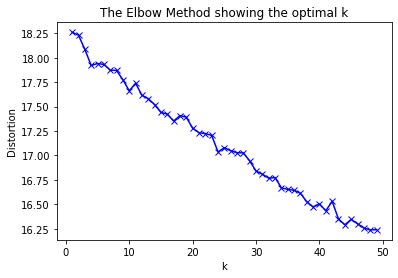

In [125]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We observe that there are many small elbow bends formed. As a result of which it becomes difficult to determine an optimal k value. We also need some domain knowledge to decide the best k. From the above chart it looks like a value of k of 10 or 26 would be better. Though we will need to confirm this again with our K-means model.